In [86]:
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt

Загрузка изображения

In [87]:
image = cv2.imread('assets/sar_3.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

1) Наиболее протяженный участок
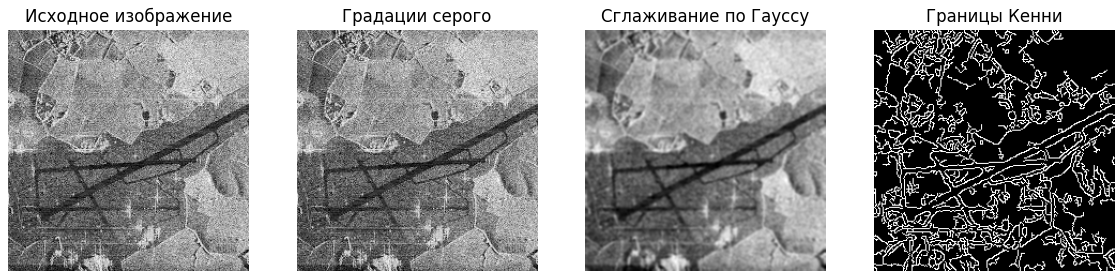

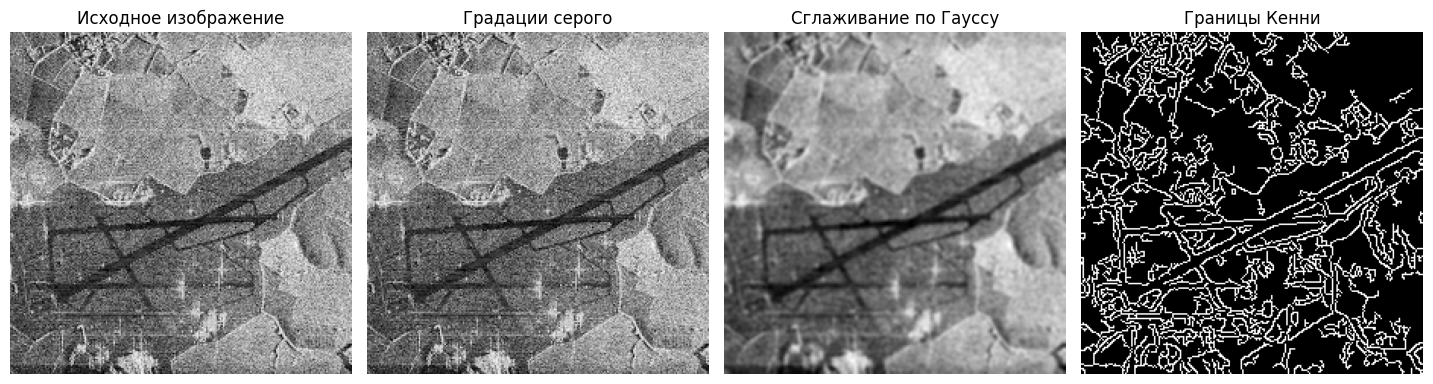

In [88]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
canny = cv2.Canny(blur, 50, 150, apertureSize=3)

lines = cv2.HoughLines(canny, 1, np.pi / 180, 120)

result = image.copy()

max_rho = 0
max_theta = 0
max_length = 0
longest_line_points = None

if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 2)

        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if length > max_length:
            max_length = length
            max_rho, max_theta = rho, theta
            longest_line_points = (x1, y1, x2, y2)

if longest_line_points is not None:
    x1, y1, x2, y2 = longest_line_points
    cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 4)

plt.figure(figsize=(18, 6))

plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(gray, cmap='gray')
plt.title('Градации серого')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(blur, cmap='gray')
plt.title('Сглаживание по Гауссу')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(canny, cmap='gray')
plt.title('Границы Кенни')
plt.axis('off')

plt.tight_layout()
plt.show()

Результат с отображением самой длинной линии
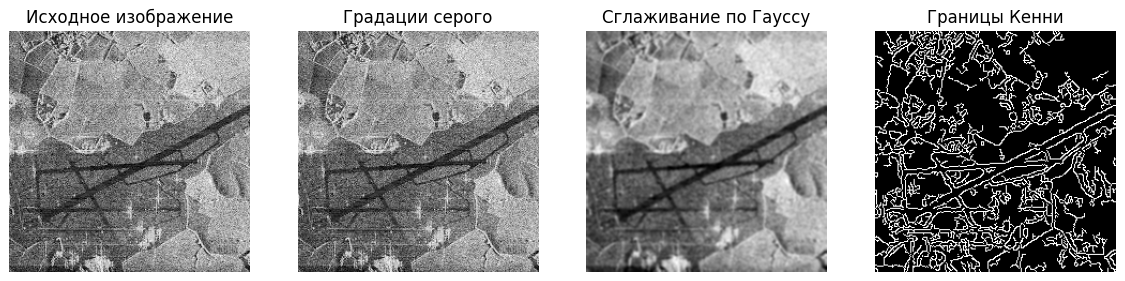

- Угол наклона: -28.0°


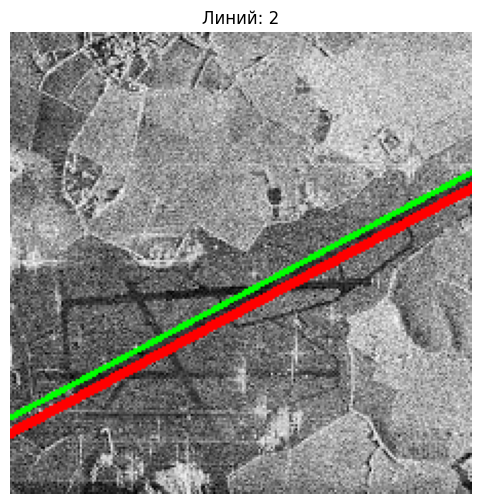

In [89]:
plt.figure(figsize=(18, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title(f'Линий: {len(lines) if lines is not None else 0}')
plt.axis('off')

if longest_line_points is not None:
    x1, y1, x2, y2 = longest_line_points
    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    print(f"- Угол наклона: {angle:.1f}°")
else:
    print("Линии не найдены")


2. Алгоритмы бинаризации

In [90]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

bin_img = copy.deepcopy(image_gray)
T = 50
bin_img[image_gray < T] = 0
bin_img[image_gray >= T] = 255

Точечная бинаризация

In [91]:
bin_img = copy.deepcopy(image_gray)
T = 50
bin_img[image_gray < T] = 0
bin_img[image_gray >= T] = 255

Бинаризация Отсу

In [92]:
_, th2 = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

Адаптивная бинаризация

In [93]:
th3 = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY, 71, 21)

Визуализация методов бинаризации

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

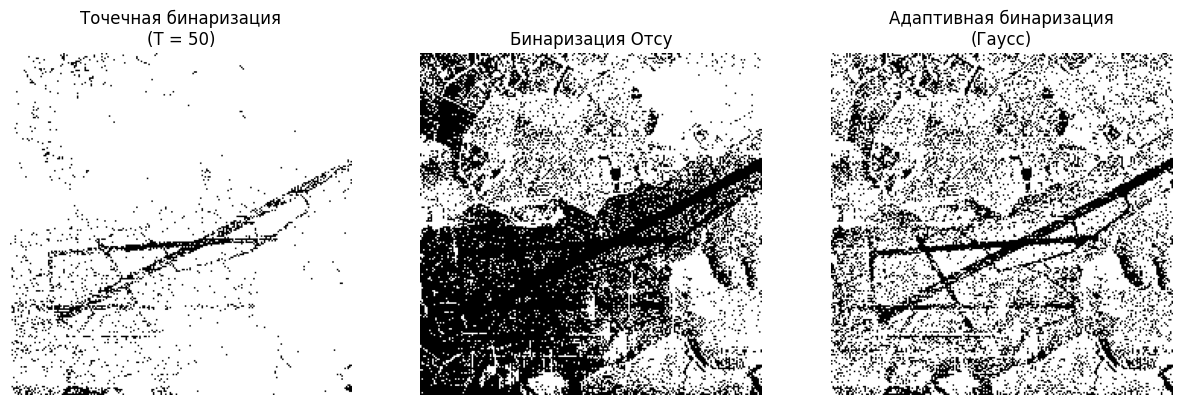

In [94]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(bin_img, cmap='gray')
plt.title('Точечная бинаризация\n(T = 50)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(th2, cmap='gray')
plt.title('Бинаризация Отсу')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(th3, cmap='gray')
plt.title('Адаптивная бинаризация\n(Гаусс)')
plt.axis('off')

Выделение дорожной полосы

In [95]:
def extract_road(binary_img, original_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        road_contour = max(contours, key=cv2.contourArea)
        result = original_img.copy()
        cv2.drawContours(result, [road_contour], -1, (0, 255, 0), 2)
        return result

    return original_img

Выделение дорожных полос для каждого метода

In [96]:
result1 = extract_road(bin_img, image)
result2 = extract_road(th2, image)
result3 = extract_road(th3, image)

Визуализация выделенных дорожных полос

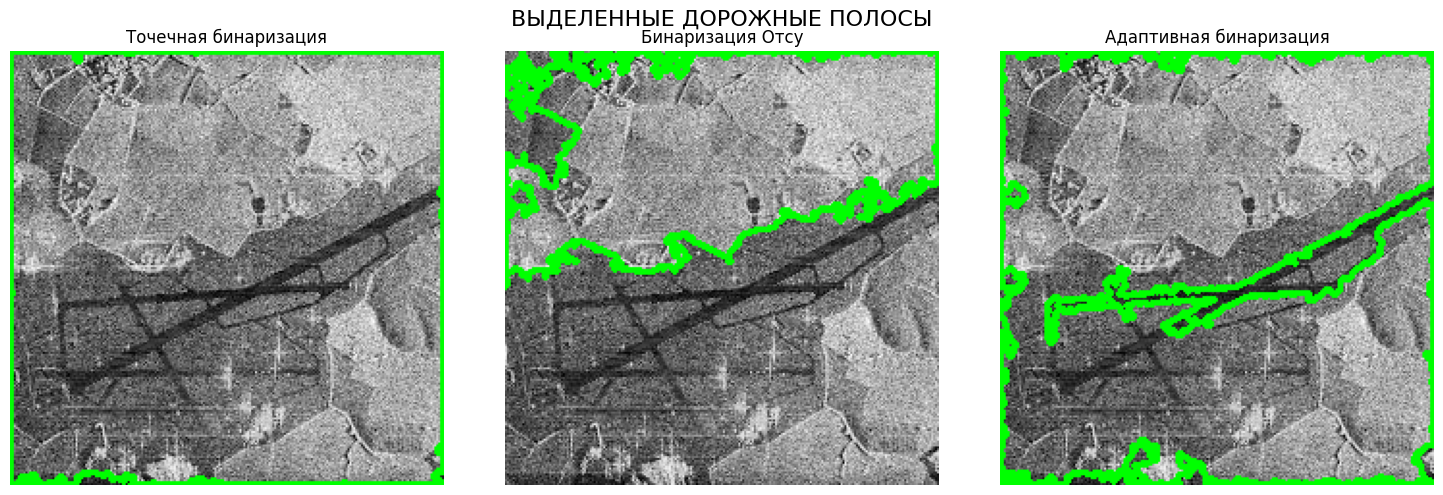

In [97]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
plt.title('Точечная бинаризация')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
plt.title('Бинаризация Отсу')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result3, cv2.COLOR_BGR2RGB))
plt.title('Адаптивная бинаризация')
plt.axis('off')

plt.suptitle("ВЫДЕЛЕННЫЕ ДОРОЖНЫЕ ПОЛОСЫ", fontsize=16)
plt.tight_layout()
plt.show()